# Image Classification

In this first notebook, we implement the classification of XXX data.

We'll be using a [dataset of XXX and XXX photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [72]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
import torchvision.models as models


We use here the **torchvision** library ([click here for more details](https://pytorch.org/vision/stable/index.html)). This library is part of the Pytorch project, and consists of popular datasets, model architectures, and common image transformations for computer vision.

## Data Augmentation and Preparation for Transfer Learning 

We randomly rotate, flip and crop the input images, in order to introduce some randomness. This will further train our network, and make our predictions more robust to image transformation. 

We also normalize the images to make them fit to the **pre-trained** XXXnet network, and thus implement transfer learning. All pre-trained models of torchvision need to be normalized the same way (with *mean = [0.485, 0.456, 0.406]* and *std = [0.229, 0.224, 0.225]*).

In [166]:
# We define the transforms for the training data and testing data
# The training data must fit the pre-trained model we will use for Transfer Learning
train_transform = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Download and load the training data
trainset = datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



Files already downloaded and verified
Files already downloaded and verified


In [214]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


We look at a batch of images to see if they have been loaded well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


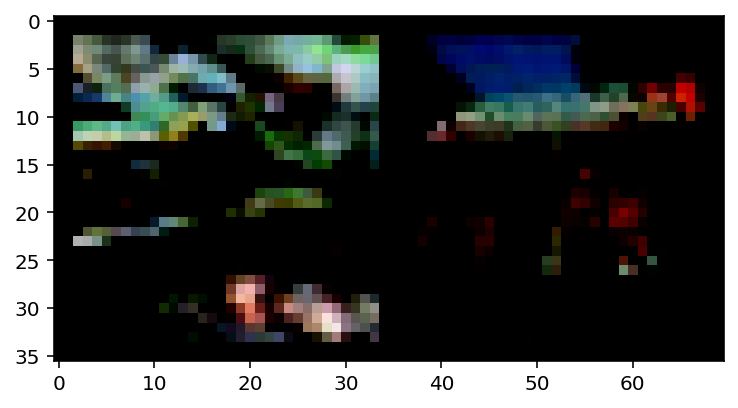

In [215]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from torch to plt image format
    plt.show()

# We get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# We show some images
imshow(utils.make_grid(images[0:2]))

## CNN Implementation (Transfer Learning)

We now implement our neuronal network, that will be divided into **2 parts**.

The first part of our neuronal network is a **pre-trained model**: the [ResNet](https://arxiv.org/abs/1512.03385) model.
This part of our network permits to detect the features of the images thanks to an efficient model that has been already trained on a lot of data.

The second part of our neuronal network is the **classifier**, that takes the output of the ResNet as input, and classifies our images thanks to the observed features.

In [216]:
# We load the pre-trained model
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [217]:
# We freeze the parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
# Take the number of features of last layer of the pre-trained model    
n_features = model.fc.in_features
    
# We write our classifier (at the position the last layer of the pre-trained model)
model.fc = nn.Sequential(
    nn.Linear(n_features, n_features//2),
    nn.ReLU(),
    nn.Linear(n_features//2, 10),
    nn.LogSoftmax(dim=1))


We use the *Cross Entropy* loss function and the *Adam* optimizer.

In [219]:
# We define the loss criterion
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# We use GPU if it's available, and the CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Training and Validation

In [222]:
optimizer.zero_grad()
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
optimizer.step()
train_loss += loss.item()*data.size(0)

In [223]:
valid_loss = 0

for images, labels in trainloader:
        valid_loss += 1
        
        
print(valid_loss*2*0.1, 's for each epoch')

400.0 s for each epoch


In [245]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss
best_accuracy = 0.0

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    running_corrects = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in trainloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in testloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
        # take as prediction the label with highest output (highest probability)
        _, pred = torch.max(output, 1)
        # total number of correct predictions
        running_corrects += torch.sum(pred == labels)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    # claculate test accuracy
    epoch_acc = running_corrects.double() / len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,epoch_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        
        


Epoch: 1 	Training Loss: 1.310994 	Validation Loss: 1.621633 	Test Accuracy: 0.440400
Validation loss decreased (inf --> 1.621633).  Saving model ...
Epoch: 2 	Training Loss: 1.313569 	Validation Loss: 1.602199 	Test Accuracy: 0.448900
Validation loss decreased (1.621633 --> 1.602199).  Saving model ...
Epoch: 3 	Training Loss: 1.308507 	Validation Loss: 1.626655 	Test Accuracy: 0.442100
Epoch: 4 	Training Loss: 1.312130 	Validation Loss: 1.622995 	Test Accuracy: 0.447600
Epoch: 5 	Training Loss: 1.303058 	Validation Loss: 1.611638 	Test Accuracy: 0.448400
Epoch: 6 	Training Loss: 1.307442 	Validation Loss: 1.608342 	Test Accuracy: 0.447600
Epoch: 7 	Training Loss: 1.303957 	Validation Loss: 1.667481 	Test Accuracy: 0.424600
Epoch: 8 	Training Loss: 1.299235 	Validation Loss: 1.615641 	Test Accuracy: 0.444500
Epoch: 9 	Training Loss: 1.304413 	Validation Loss: 1.613477 	Test Accuracy: 0.447400
Epoch: 10 	Training Loss: 1.296578 	Validation Loss: 1.617545 	Test Accuracy: 0.447000


## DATA LOADING: VEDERE PERCHE NON FUNZIONAVA !!!
